In [1]:
import os
import requests
import json
import re
import glob
import datetime
import numpy as np
from itertools import cycle, islice
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pandas as pd

In [2]:
MODELED = './modeled/'
SELFSERVE = './self-serve/'

In [3]:
builder = SparkSession.builder.appName("Self Serve - Analytics")
builder.config(
    "spark.hadoop.mapreduce.fileoutputcommitter.algorithm.version", "2")
builder.config("spark.speculation", "false")
builder.config("spark.sql.parquet.compression.codec", "gzip")
builder.config("spark.debug.maxToStringFields", "100")
builder.config("spark.driver.memory", "2g")
builder.config("spark.driver.cores", "1")
builder.config("spark.executor-memory", "6g")
builder.config("spark.executor.cores", "5")
builder.master("local[*]")

spark = builder.getOrCreate()

In [4]:
spark

In [5]:
aux = glob.glob(MODELED + '/*.parquet')

In [6]:
files = {}
for item in aux:
    files[item.replace(MODELED, '').replace('.parquet', '')] = item
files

{'aluno': './modeled/aluno.parquet',
 'curso': './modeled/curso.parquet',
 'logizz': './modeled/logizz.parquet',
 'log_aula': './modeled/log_aula.parquet',
 'matricula': './modeled/matricula.parquet',
 'pedido': './modeled/pedido.parquet',
 'transacao_pagseguro': './modeled/transacao_pagseguro.parquet',
 'user': './modeled/user.parquet'}

In [7]:
# Insigths de alunos
aluno_dataframe = spark.read.parquet(files['aluno'])
aluno_dataframe = aluno_dataframe.withColumn("estado", trim(upper(col("estado"))))

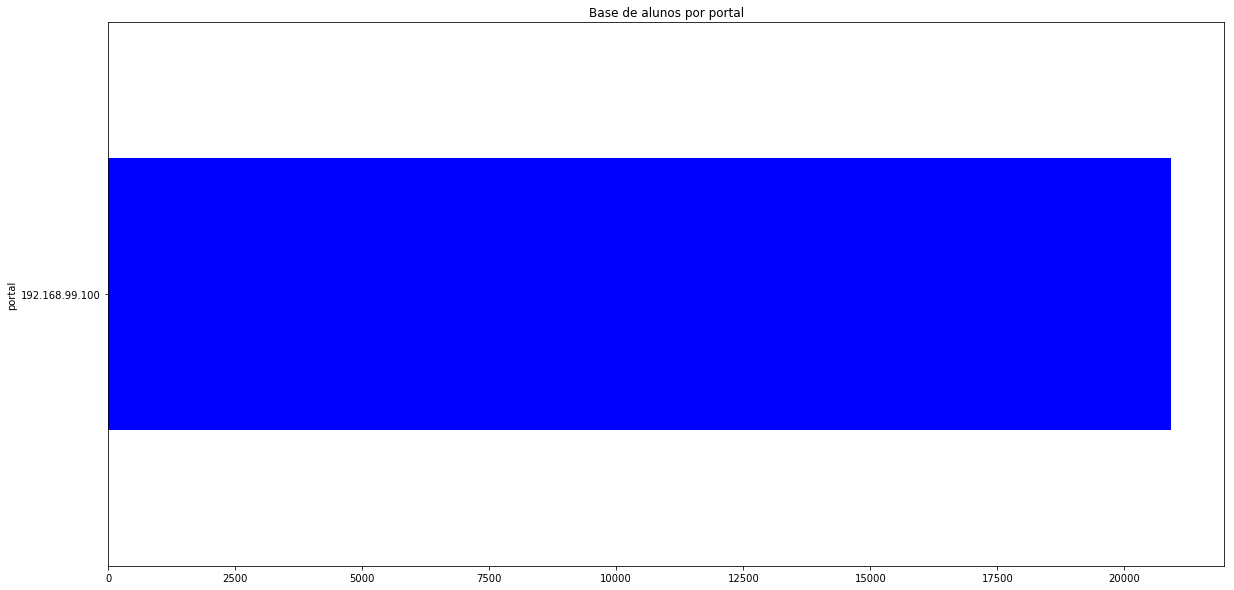

In [8]:
#total de alunos cadastrados por cada cliente Thinkr
alunos_totais_por_cliente = aluno_dataframe.groupBy(['domain']).count().orderBy('count', ascending=0)
alunos_totais_por_cliente = alunos_totais_por_cliente.select(col("domain").alias("portal"), col("count").alias("alunos"))
alunos_totais_por_cliente.write.mode('overwrite').parquet(SELFSERVE+"alunos_totais_por_cliente.parquet")
alunos_totais_por_cliente = alunos_totais_por_cliente.toPandas()
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(alunos_totais_por_cliente)))
alunos_totais_por_cliente.plot(x='portal', y='alunos', rot=0, title='Base de alunos por portal', figsize=(20,10), color=my_colors, kind='barh', legend=False)

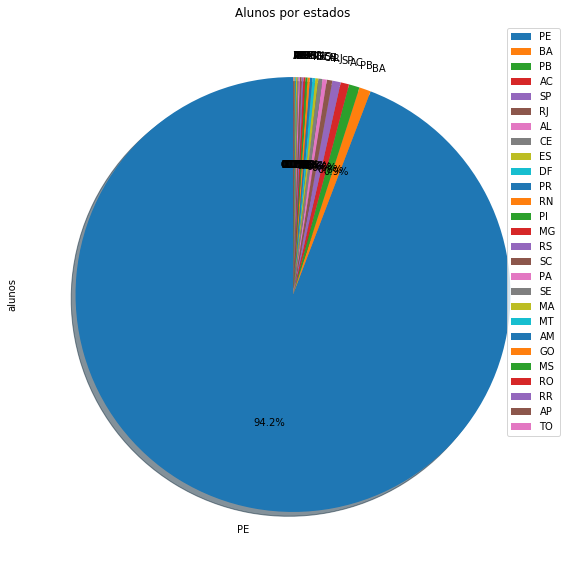

In [9]:
#percentual de alunos por estado
clientes_por_estado = aluno_dataframe.groupBy(['estado']).count().orderBy('count', ascending=0)
clientes_por_estado = clientes_por_estado.select(col("estado").alias("estado"), col("count").alias("alunos")).filter(col('estado') != 'None').filter(col('estado') != '')
clientes_por_estado.write.mode('overwrite').parquet(SELFSERVE+"clientes_por_estado.parquet")
clientes_por_estado = clientes_por_estado.toPandas()
clientes_por_estado.set_index('estado',inplace=True)
clientes_por_estado.plot(
    title='Alunos por estados', 
    kind='pie', 
    y='alunos', 
    autopct='%1.1f%%', 
    shadow=True, 
    startangle=90,  
    figsize=(20,10)
)

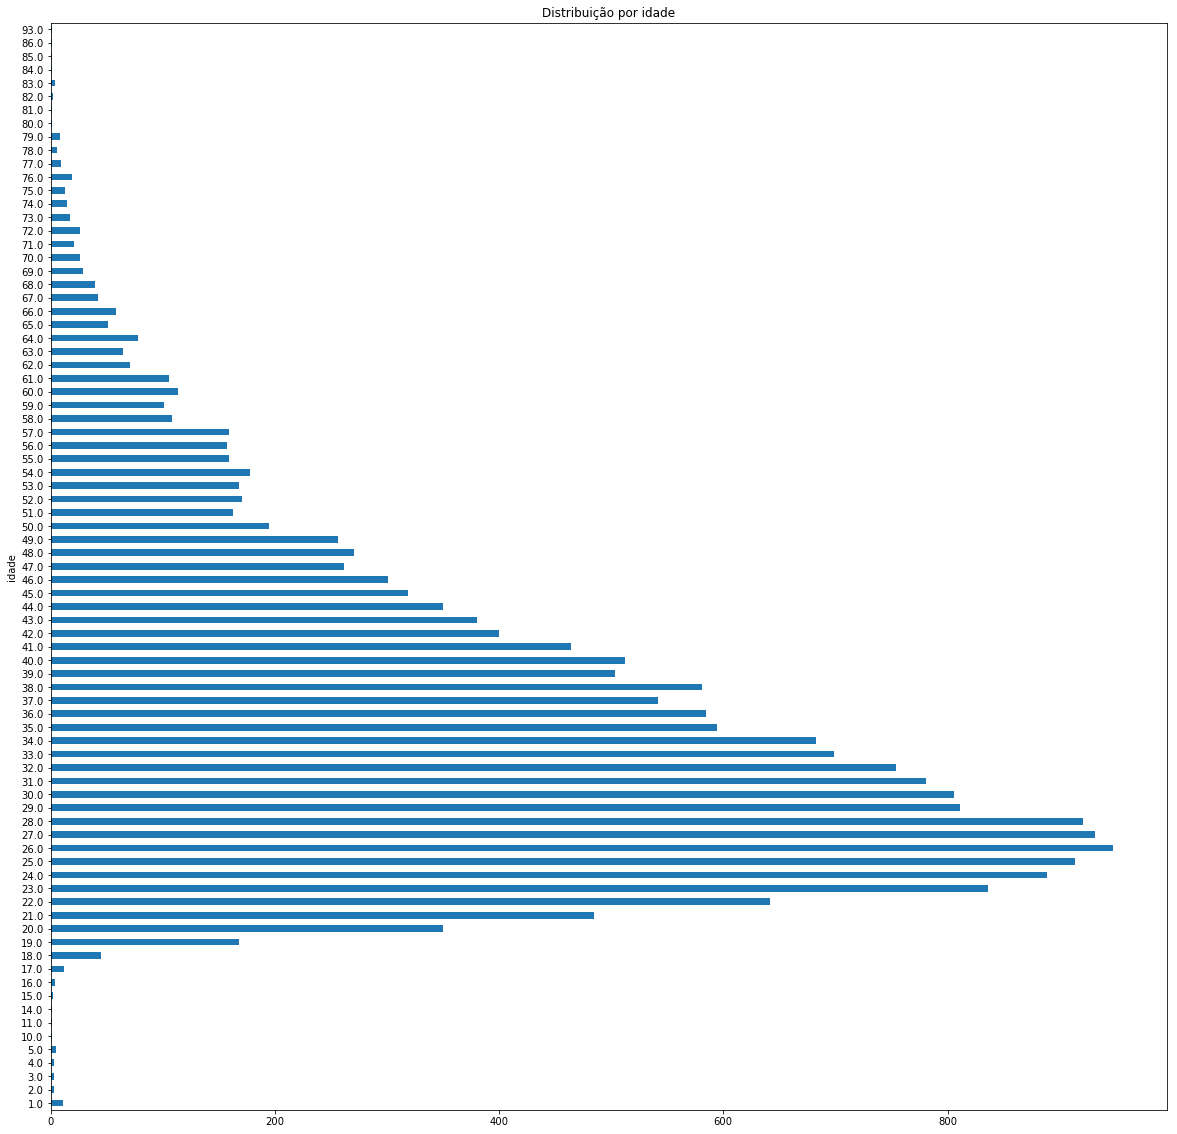

In [10]:
#gráfico de dispersão por idade
dispersao_idade = aluno_dataframe.select(col("data_nascimento")).filter(col('data_nascimento') != 'None').filter(col('data_nascimento') != '')
dispersao_idade = dispersao_idade.withColumn("idade", round(datediff(to_date(lit(datetime.datetime.now()), 'yyyy-MM-dd'), to_date("data_nascimento","yyyy-MM-dd"))/365))
dispersao_idade = dispersao_idade.filter(col('idade') < 100).filter(col('idade') > 0)
dispersao_idade = dispersao_idade.groupby(['idade']).count().orderBy('idade', ascending=1)
dispersao_idade.write.mode('overwrite').parquet(SELFSERVE+"dispersao_idade.parquet")
dispersao_idade = dispersao_idade.toPandas()
dispersao_idade.plot(x='idade', y='count', rot=0, title='Distribuição por idade', figsize=(20,20), kind='barh', legend=False)

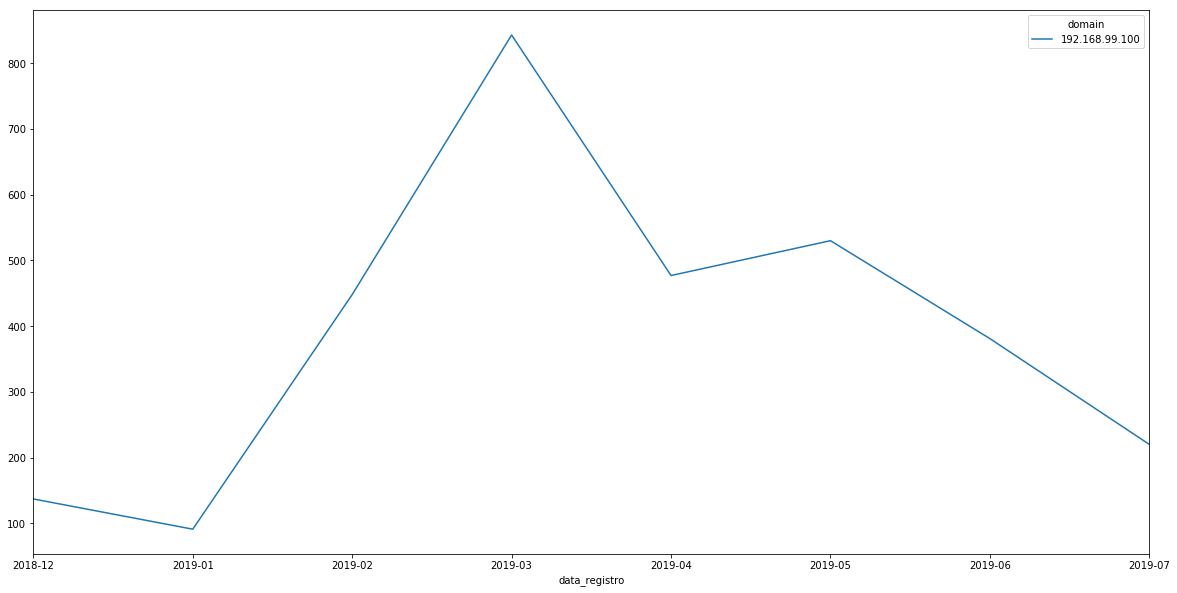

In [11]:
#cadastros de alunos nos últimos 8 meses por cliente
cadastros_meses_dominios = aluno_dataframe.select(date_format(col("data_registro"),'yyyy-MM').alias('data_registro'), col('domain')).filter(col('data_registro') != 'None').filter(col('data_registro') != '').filter(col('data_registro') >= to_date(date_sub(lit(datetime.datetime.now()), 240), 'yyyy-MM-dd'))
cadastros_meses_dominios = cadastros_meses_dominios.groupby(['domain', 'data_registro']).count().orderBy(['domain', 'data_registro'], asceding=1)
cadastros_meses_dominios.write.mode('overwrite').parquet(SELFSERVE+"cadastros_meses_dominios.parquet")
cadastros_meses_dominios = cadastros_meses_dominios.toPandas()
cadastros_meses_dominios = cadastros_meses_dominios.pivot(index='data_registro', columns='domain', values='count')
cadastros_meses_dominios.plot(figsize=(20,10))

In [12]:
pedidos_dataframe = spark.read.parquet(files['pedido'])
matriculas_dataframe = spark.read.parquet(files['matricula'])
matriculas_dataframe = matriculas_dataframe.select(
        col('id').alias('mt_id'),     
        col('pedido_id'),     
        col('status').alias('mt_status'),
        col('domain').alias('mt_domain'),
        col('curso_valor').alias('mt_valor'),
        col('data_expiracao').alias('mt_data_expiracao'),
        col('curso_id')
)
pedidos_dataframe = pedidos_dataframe.join(matriculas_dataframe,  [pedidos_dataframe.id == matriculas_dataframe.pedido_id, pedidos_dataframe.domain == matriculas_dataframe.mt_domain])

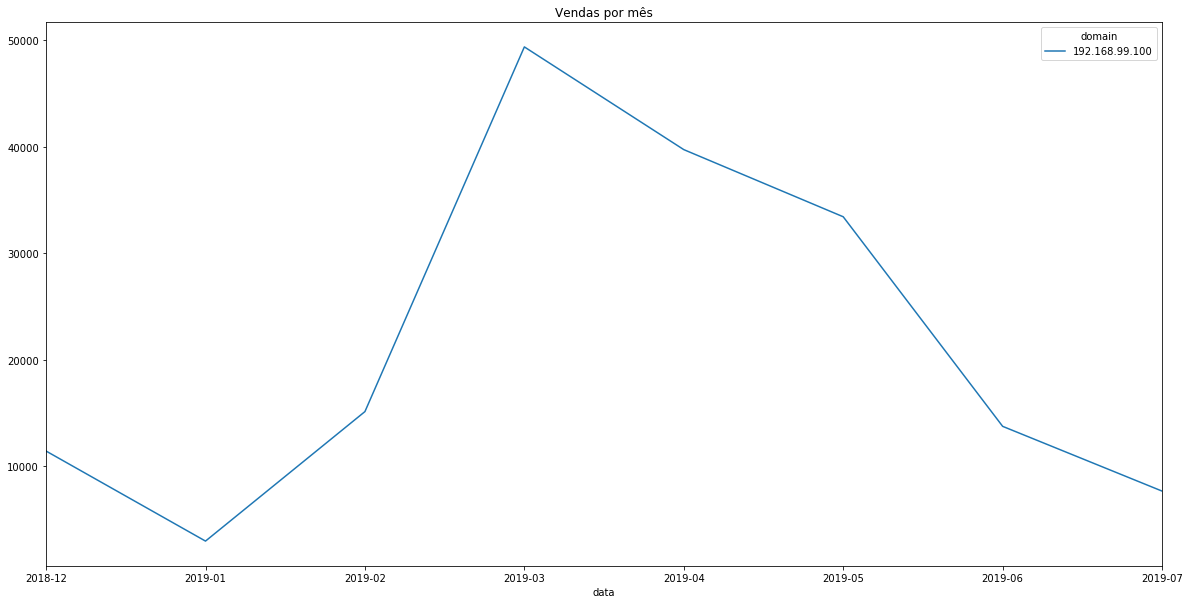

In [13]:
vendas_por_mes = pedidos_dataframe.select(date_format(col("data"),'yyyy-MM').alias('data'), col('domain'), col('mt_valor')).filter(col('data') != 'None').filter(col('data') != '').filter(col('data') >= to_date(date_sub(lit(datetime.datetime.now()), 240), 'yyyy-MM-dd')).filter(col('status') == 'Liberado')
vendas_por_mes = vendas_por_mes.groupby(['domain', 'data']).sum('mt_valor').withColumnRenamed('sum(mt_valor)', 'total').orderBy(['domain', 'data'], ascending=1)
vendas_por_mes.write.mode('overwrite').parquet(SELFSERVE+"vendas_por_mes.parquet")
vendas_por_mes = vendas_por_mes.toPandas()
vendas_por_mes = vendas_por_mes.pivot(index='data', columns='domain', values='total')
vendas_por_mes.plot(figsize=(20,10), title='Vendas por mês')

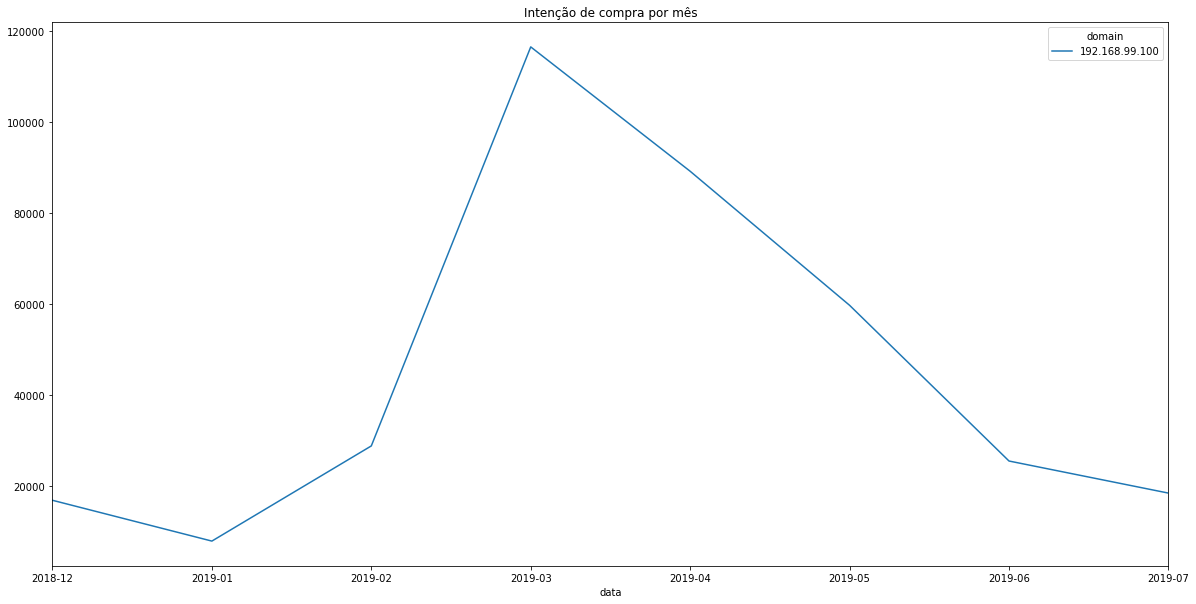

In [14]:
intencao_por_mes = pedidos_dataframe.select(date_format(col("data"),'yyyy-MM').alias('data'), col('domain'), col('mt_valor')).filter(col('data') != 'None').filter(col('data') != '').filter(col('data') >= to_date(date_sub(lit(datetime.datetime.now()), 240), 'yyyy-MM-dd'))
intencao_por_mes = intencao_por_mes.groupby(['domain', 'data']).sum('mt_valor').withColumnRenamed('sum(mt_valor)', 'total').orderBy(['domain', 'data'], ascending=1)
intencao_por_mes.write.mode('overwrite').parquet(SELFSERVE+"intencao_por_mes.parquet")
intencao_por_mes = intencao_por_mes.toPandas()
intencao_por_mes = intencao_por_mes.pivot(index='data', columns='domain', values='total')
intencao_por_mes.plot(figsize=(20,10), title='Intenção de compra por mês')

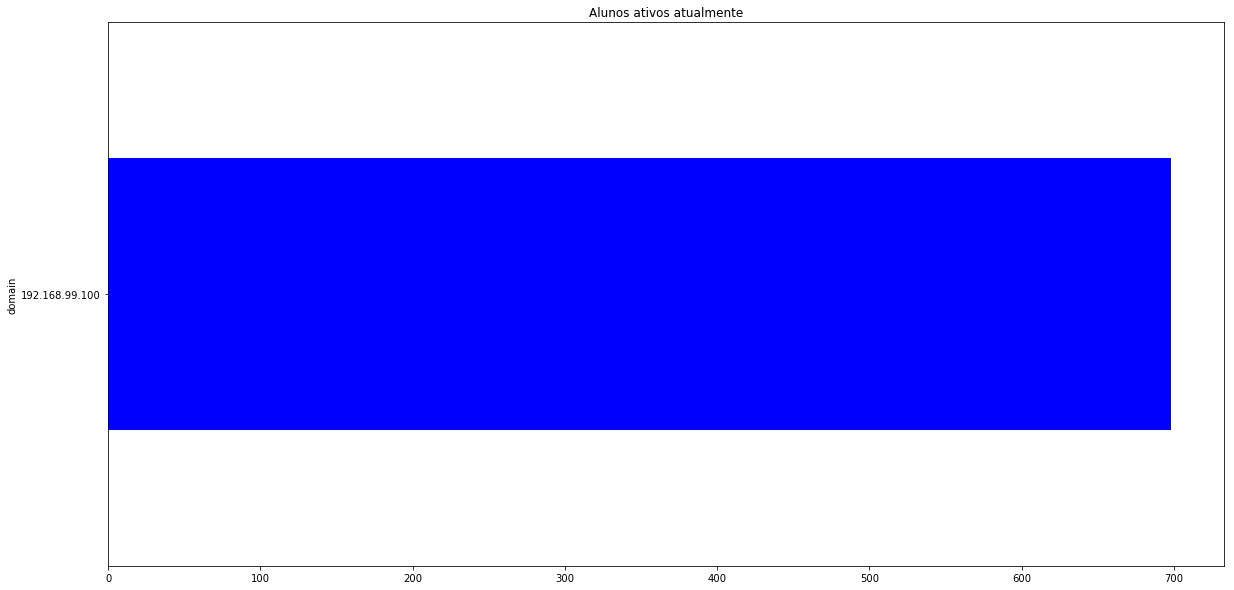

In [15]:
alunos_ativos = matriculas_dataframe.select(col('mt_domain').alias('domain')).filter(col('status') == 'Matriculado').filter(col('mt_data_expiracao') >= to_date(lit(datetime.datetime.now()), 'yyyy-MM-dd')).groupby(['domain']).count().orderBy('count', ascending=0)
alunos_ativos.write.mode('overwrite').parquet(SELFSERVE+"alunos_ativos.parquet")
alunos_ativos = alunos_ativos.toPandas()
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(alunos_ativos)))
alunos_ativos.plot(x='domain', y='count', rot=0, title='Alunos ativos atualmente', figsize=(20,10), color=my_colors, kind='barh', legend=False)

In [16]:
alunos_ativos

,domain,count
0,192.168.99.100,698
